<h1><center> Denoising Variational Autoencoder </center></h1>


  <center>  <img src=https://drive.google.com/uc?id=1A6QMi7EGwnyeee8DsD7UJ0V_ssWyCNNE " width="700">  </center> 

### Cristiano De Nobili - My Contacts
For any questions or doubts you can find my contacts here:

<p align="center">

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Instagram_logo_2016.svg/2048px-Instagram_logo_2016.svg.png" width="20">](https://www.instagram.com/denocris/?hl=it)
[<img src="https://1.bp.blogspot.com/-Rwqcet_SHbk/T8_acMUmlmI/AAAAAAAAGgw/KD_fx__8Q4w/s1600/Twitter+bird.png" width="30">](https://twitter.com/denocris) 
[<img src="https://loghi-famosi.com/wp-content/uploads/2020/04/Linkedin-Simbolo.png" width="40">](https://www.linkedin.com/in/cristiano-de-nobili/)     

</p>

or here (https://denocris.com).

### Useful Links

All notebooks can be found [here!](https://drive.google.com/drive/folders/1i3cNfzWZTNXfvkFVVIIDXjRDdSa9L9Dv?usp=sharing)

Introductory slides [here!](https://www.canva.com/design/DAEa5hLfuWg/-L2EFFfZLVuiDkmg4KiKkQ/view?utm_content=DAEa5hLfuWg&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink)

Collection of references: [here!](https://denocris.notion.site/Deep-Learning-References-0c5af2dc5c8d40baba19f1328d596fff)


### Some Refs

* [What is a Variational Autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

* [Variational Autoencoder by Jonathan Hui](https://jhui.github.io/2017/03/06/Variational-autoencoders/)

* [Variational autoencoders by Jeremy Jordan](https://www.jeremyjordan.me/variational-autoencoders/)

* [Understanding Variational Autoencoders (VAEs) by Joseph Rocca](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73#:~:text=In%20variational%20autoencoders%2C%20the%20loss,makes%20the%20latent%20space%20regular)

* Original Papers: [Kingma et al.](https://arxiv.org/abs/1312.6114) and [Rezende et al.](https://arxiv.org/abs/1401.4082)




In [ ]:
import math as m
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchsummary import summary


from IPython import display

## <h1><center>  Information Theory Background 


### Self-Information

The idea behind self-information is the following

* if an event always occurs, we associate it with a smaller amount of information. It will not suprise us!
* On the other side, a rare event is associated with a huge amount of information. It will suprise us!

I am not surprise to see the sunrise every morning (likely event). Instead,  I would be really suprised if tomorrow the Sun will not rise (unlikely event). This amount of surprise or self-information of the event $x$ is quantified by

$$I(x) = - \log p(x),$$

where $p(x)$ is the probability of the event $x$. If $p(x)=1$, then self-info is zero. A rare event instead has a huge surpise factor.

### Shannon Entropy 

In terms of self-info, Shannon Entropy is the average self-information (expected value) over all possible values of X.
The entropy for a probability $p(x)$ distribution is

$$ S = - \sum_i p(x_i) \log p(x_i),$$

where we assume we know the probability $p$ for each outcome $i$. If we use $log_2$  for our calculation we can interpret entropy as *the minimum number of bits it would take us to encode our information*.

For continous variables, we can use the integral form

$$ S = - \int  p(x) \log p(x) \, dx,$$

where now $p(x)$ is taking the role of a probability density function (PDF). Take in mind that a broad probability density has higher entropy than a narrowed one (think about Gaussian distribution vs delta Dirac, which has $S=0$).

In both discrete and continous formulation, we are computing the expectation (i.e. average) of the negative log-probability (i.e. self-info) which is the theoretical minimum encoding size of the information from the event $x$. The same formula is usually written as

$$S = \mathbb E _{\, x \sim p} \left[ -\log p(x) \right],$$

where $x \sim p$ means that we calculate the expectation with the probability distribution $p$.

Let's give an example! 

<!---
  REMIND to change open with uc
 https://drive.google.com/open?id=1Y52T3Z4dwRU4Rq5L5bEVYh0d3kU0aVB8
--->

  <center>  <img src=https://drive.google.com/uc?id=1GaAeK8xIZCVDRb-oHQNUzRuoOprFh1eS " width="700">  </center> 

Let's say we have to pass a message about what drink Cristiano would take during an event. In general, Cristiano loves [Midori Sour](https://drizly.com/midori-sour/r-b972d5282bec6fe8) , Daiquiri, Spritz and Wine.

On Monday, Cristiano loves to listen Jazz and the probability distribution of his choice is: 

$$P(\text Midori ) =  P(\text Daiquiri ) = P(\text Spritz ) = P(\text Wine ) = 0.25,$$

while the corresponding entropy

$$S = - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} = 2$$

On Wednesday, he usually meets with some friends after work: 

$$P(\text Midori ) = 0.125,\;  P(\text Daiquiri ) =0.125,\;  P(\text Spritz ) = 0.5,\; P(\text  Wine ) = 0.25,$$

while the corresponding entropy

$$S = - \frac{1}{8} \log \frac{1}{8} - \frac{1}{8} \log \frac{1}{8} - \frac{1}{2} \log \frac{1}{2} - \frac{1}{4} \log \frac{1}{4} = 1.75$$


On Thursday, he often goes to an event where cocktail attire dress code is required

$$P(\text Midori ) = 0.95,\;  P(\text Daiquiri ) =0.02,\;  P(\text Spritz ) = 0.018,\; P(\text  Wine ) = 0.012,$$

and the corresponding entropy

$$S = - 0.95 \log 0.95 - 0.02 \log 0.02 - 0.018 \log 0.018 - 0.012 \log 0.012 = 0.364$$

In [ ]:
# On Monday, all drinks have equal probability to be chose
entropy_1 = -0.25*m.log(0.25,2)-0.25*m.log(0.25,2)-0.25*m.log(0.25,2)-0.25*m.log(0.25,2)
print('On Monday, high entropy: ', entropy_1)

# On Wednesday, some are more probable than others
entropy_2 = -0.5*m.log(0.5,2)-0.25*m.log(0.25,2)-0.125*m.log(0.125,2)-0.125*m.log(0.125,2)
print('On Wednesday, medium entropy: ', entropy_2)

# On Thursday, one drink is by far the most probable
entropy_3 = -0.95*m.log(0.95,2)-0.02*m.log(0.02,2)-0.018*m.log(0.018,2)-0.012*m.log(0.012,2)
print('On Thursday, low entropy: ', entropy_3)

On Monday, high entropy:  2.0
On Wednesday, medium entropy:  1.75
On Thursday, low entropy:  0.36407300467232967


If entropy is high (encoding size $log_2 p(x)$ is big on average), it means we have many message types with small and almost equal probabilities. Hence, every time a new message arrives, you would expect a different type than previous messages. You may see it as a disorder or uncertainty or unpredictability.

On the contrary, when a message has much smaller probability than other message, it appears as a surprise because on average you would expect other more frequently sent message types. Moreover, a rare message type has more information than more frequent message types because it eliminates a lot of other probabilities and tells us more specific information.

In the drink scenario, by sending “Wine” on thursday which happens 1.2% of the times, we are reducing the uncertainty by 98.8% of the probability distribution (“Midori, Daiquiri, Spritz”) provided we had no information before. If we were sending “Midori” (95%) instead, we would be reducing the uncertainty by 5% only.

If the entropy is high (ex: fair coin), the average encoding size is significant which means each message tends to have more (specific) information. Again, this is why high entropy is associated with disorder, uncertainty, surprise, unpredictability, amount of information. The more random a message is, the more information will be gained from decoding the message.

Low entropy (ex: sunrise) means that most of the times we are receiving the more predictable information which means less disorder, less uncertainty, less surprise, more predictability and less (specific) information. This is the Thursday case.

### Cross Entropy

Suppose to have two distributions, the true one $p(x)$ and the estimated $q(x)$. In the language of neural networks, $p(x)$ would be the grond truth (labels in one hot-encoding) and $q(x)$ the outcome of the net, i.e. the one that your machine learning algorithm is trying to match. Cross entropy is a mathematical tool for comparing two probability distributions $p(x)$ and $q(x)$ and it is expressed by the formula 

$$ H (p,q) = - \int p(x) \log q(x)\,dx.$$

If $\log$ is in base $2$, then cross entropy measures the number of bits you will need encoding symbols from $p$ using the wrong distribution $q$. Subtracting to cross entropy the entropy of $p$, you are counting the cost in terms of bits of using the wrong distribution $q$ (this somehow will be KL-divergence). 

### Kullback-Leibler Divergence

KL-divergence is just a slight modification of our formula for entropy. Rather than just having our probability distribution $h$ we add into the game our approximating distribution $g$. Then we look at the difference of the log values for each

$$D_{KL}(h || g) = - \sum_i h(x_i) (\log h(x) - \log g(x)) = - \sum_i h(x_i) \log \frac{h(x)}{g(x)}$$ 

KL-divergence is the expectation of the log-difference between the probability of data in the original distribution $h$ with the approximating distribution $g$. Again, if we think in terms of $\log_2$ we can interpret this as how many bits of information we expect to lose when we choose an approximation $g$ of our original ditribution $h$. 

In the variational autoencoder loss function, the KL-divergence is used to force the distribution of latent variables $q(z | x)$ to be a normal distribution $n(z)$ so that we can sample latent variables from the normal distribution. As such, the KL-divergence is included in the loss function to improve the similarity between the distribution of latent variables and the normal distribution. More about **KL** can be found [here](https://towardsdatascience.com/demystifying-kl-divergence-7ebe4317ee68) and about **cross-entropy** [here](https://towardsdatascience.com/demystifying-cross-entropy-e80e3ad54a8).

##  Autoencoder vs Variational Autoencoder

<center>  
<p>      
<img src=https://drive.google.com/uc?id=1QdiSESYkbNnigrbH-GutlGtRuC6QbGpw  width="800" height="250">  
<img src=https://drive.google.com/uc?id=1IiuzC8YeZ_MXJsYg1BgJV-o3VMoQUGvI width="800" height="250">    
 <p>
</center> 

## <h1><center> Coding our Denoising VAE

### Importing Data and Add some Gaussian Noise

In [ ]:
# set the seed: built-in python, numpy, and pytorch
seed = 172
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # works for all devices (CPU and GPU)

In [ ]:
%%capture
#clean images
train_images = MNIST('./data', train=True, download=True).data.numpy()
test_images = MNIST('./data', train=False, download=True).data.numpy()


##########################
# image pixels in [0,1]
#########################

# clean images normalization
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0


##########################
# compute mean and std (you can normalize also wrt to mean and std)
#########################

print('Clean images values: ')
print('Train mean and std: %f  %f' %(train_images_norm.mean(), train_images_norm.std()))
print('Test mean and std: %f  %f' %(test_images_norm.mean(), test_images_norm.std()))


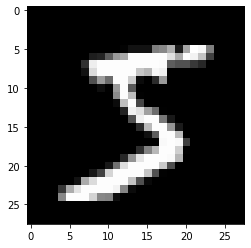

In [ ]:
image = train_images[0]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [ ]:
'''
noisy_image = train_images_noisy[0]
noisy_image = np.array(noisy_image, dtype='float')
pixels = noisy_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
'''

"\nnoisy_image = train_images_noisy[0]\nnoisy_image = np.array(noisy_image, dtype='float')\npixels = noisy_image.reshape((28, 28))\nplt.imshow(pixels, cmap='gray')\nplt.show()\n"

### Transforming Data in Dataloader

In [ ]:
# Build Clean Dataset

batch_size = 128


train_images_norm = torch.tensor(train_images_norm).view(60000, 1, 28, 28)
test_images_norm = torch.tensor(test_images_norm).view(10000, 1, 28, 28)


# Clean Set
# DataLoader: combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = DataLoader(train_images_norm, batch_size=batch_size ,shuffle=False)
# Splitting the test images (tot 10k) in valid and test set.
valid_loader_tmp, test_loader_tmp = random_split(test_images_norm, [7000, 3000]) 
valid_loader = DataLoader(valid_loader_tmp, batch_size=batch_size , shuffle=False)
test_loader = DataLoader(test_loader_tmp, batch_size=batch_size , shuffle=False)



In [ ]:
# Build Noisy Dataset

batch_size = 128
noise_variance = 0.2

train_images_norm_noisy = train_images_norm + torch.randn_like(train_images_norm)*noise_variance
test_images_norm_noisy = test_images_norm + torch.randn_like(test_images_norm)*noise_variance

train_loader_noisy = DataLoader(train_images_norm_noisy, batch_size=batch_size ,shuffle=False)
# Splitting the test images (tot 10k) in valid and test set.
valid_loader_tmp, test_loader_tmp = random_split(test_images_norm_noisy, [7000, 3000]) 
valid_loader_noisy = DataLoader(valid_loader_tmp, batch_size=batch_size , shuffle=False)
test_loader_noisy = DataLoader(test_loader_tmp, batch_size=batch_size , shuffle=False)

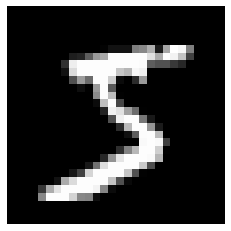

In [ ]:
image = train_images_norm[0]
plt.imshow(image[0, :, :], cmap='gray')
plt.axis('off')
plt.show()

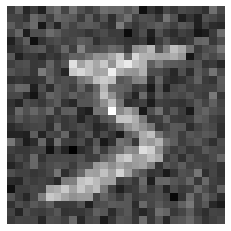

In [ ]:
image =train_images_norm_noisy[0]
plt.imshow(image[0, :, :], cmap='gray')
plt.axis('off')
plt.show()

### Using Class to define a Model (From TensorFlow Official Page)

   
```python
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

model = MyModel()
```


$\frac{d f (g ( h (w)))}{dw} = \frac{df}{dg(h)}\frac{dg(h)}{dh}\frac{d h(w)}{dw}$

### Defining our Variational Autoencoder Model
<center>  <img src=https://drive.google.com/uc?id=14dNERtYBOiyEq3cPOUFObUe6Ul4cn_r0  " width="800">  </center> 

Just as a standard autoencoder, a variational autoencoder is an architecture composed of both an encoder and a decoder and that is trained to minimise the reconstruction error between the encoded-decoded data and the initial data. However, in order to introduce some regularisation of the latent space, we proceed to a slight modification of the encoding-decoding process: instead of encoding an input as a single point, we encode it as a distribution over the latent space. The model is then trained as follows:

* first, the input is encoded as distribution over the latent space
* second, a point from the latent space is sampled from that distribution
* third, the sampled point is decoded and the reconstruction error can be computed
* finally, the reconstruction error is backpropagated through the network

In practice, the encoded distributions are chosen to be normal so that the encoder can be trained to return the mean and the covariance matrix that describe these Gaussians. The reason why an input is encoded as a distribution with some variance instead of a single point is that it makes possible to express very naturally the latent space regularisation: the distributions returned by the encoder are enforced to be close to a standard normal distribution. We will see in the next subsection that we ensure this way both a local and global regularisation of the latent space (local because of the variance control and global because of the mean control).

Thus, the loss function that is minimised when training a VAE is composed of a 

* ***reconstruction term*** (on the final layer), that tends to make the encoding-decoding scheme as performant as possible;
* ***regularisation term*** (on the latent layer), that tends to regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution. Without this term, VAE will act like a basic autoencoder, which may lead to overfitting, and we won’t have the generative properties that we desire.

In [ ]:
class VarAutoEncoder(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int):
        super(VarAutoEncoder, self).__init__()

        self.latent_dim = latent_dim  # self is used when the object will be used in the methods


        hidden_dims = [8, 16, 32]           # [128, 256, 512]

        # Build Encoder  
        conv2d_1 = nn.Sequential(
                   nn.Conv2d(in_channels, out_channels=hidden_dims[0], kernel_size= 3, stride= 2, padding  = 1),
                   nn.BatchNorm2d(hidden_dims[0]),
                   nn.LeakyReLU())
        
        conv2d_2 = nn.Sequential(
                   nn.Conv2d(hidden_dims[0], out_channels=hidden_dims[1], kernel_size= 3, stride= 2, padding  = 1),
                   nn.BatchNorm2d(hidden_dims[1]),
                   nn.LeakyReLU())
        
        conv2d_3 = nn.Sequential(
                   nn.Conv2d(hidden_dims[1], out_channels=hidden_dims[2], kernel_size= 3, stride= 2, padding  = 1),
                   nn.BatchNorm2d(hidden_dims[2]),
                   nn.LeakyReLU())
        
        modules = [conv2d_1, conv2d_2, conv2d_3]


        self.encoder = nn.Sequential(*modules)

        self.fc_mu = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4 * 4)

        hidden_dims.reverse()

        first_output_padding = 0
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=first_output_padding),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
            first_output_padding = 1



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        Input tensor to encoder [N x C x H x W]
        """
        result = self.encoder(input)
        #print(result.size())
        result = torch.flatten(result, start_dim=1)
        #print(result.size())

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        """
        result = self.decoder_input(z)
        result = result.view(-1, 32, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        result = torch.sigmoid(result)
        return result

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        mu: mean of the latent Gaussian
        log_var: standard deviation of the latent Gaussian
        """
        std = torch.exp(0.5 * log_var)
        # eps \sim N(0,1)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def sample(self,
               num_samples,
               current_device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        num_samples: number of samples
        current_device: device to run the model
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        #z = z.to(current_device)

        samples = self.decode(z)
        return samples

##### Reparametrization Trick

The overall architecture is then obtained by concatenating the encoder and the decoder parts. However we still need to be very careful about the way we sample from the distribution returned by the encoder during the training. The sampling process has to be expressed in a way that allows the error to be backpropagated through the network. A simple trick, called ***reparametrisation trick***, is used to make the gradient descent possible despite the random sampling that occurs halfway of the architecture and consists in using the fact that if z is a random variable following a Gaussian distribution with mean $m(x)$ and with covariance $s(x)$. Then it can be expressed as:

$$z = m(x) + s(x)\epsilon .$$

[Here a more detailed explanation!](http://gregorygundersen.com/blog/2018/04/29/reparameterization/)

In [ ]:
model = VarAutoEncoder(in_channels=1, latent_dim = 50)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.cuda() 

from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
       BatchNorm2d-2            [-1, 8, 14, 14]              16
         LeakyReLU-3            [-1, 8, 14, 14]               0
            Conv2d-4             [-1, 16, 7, 7]           1,168
       BatchNorm2d-5             [-1, 16, 7, 7]              32
         LeakyReLU-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 4, 4]           4,640
       BatchNorm2d-8             [-1, 32, 4, 4]              64
         LeakyReLU-9             [-1, 32, 4, 4]               0
           Linear-10                   [-1, 50]          25,650
           Linear-11                   [-1, 50]          25,650
           Linear-12                  [-1, 512]          26,112
  ConvTranspose2d-13             [-1, 16, 7, 7]           4,624
      BatchNorm2d-14             [-1, 1

### Gaussian Distribution and Loss Function

The Gaussian distribution is defined by

$$ N (x\mid \mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}} .$$


Taking its log we obtain

$$ \log N (x\mid \mu ,\sigma ^{2})= - \frac{1}{2} \left( \log2\pi  + \log \sigma ^2  +  \frac {(x-\mu )^{2}}{\sigma ^{2}}\right) = - \frac{1}{2} \left( \log2\pi  + \log\sigma ^2 +  (x-\mu )^{2} \exp (- \log\sigma^2)\right).$$

Therefore the KL-Divergence is:

$$\sum_z N (z\mid \mu ,\sigma ^{2})\;(\log N (x\mid \mu ,\sigma ^{2})- \log N(0 ,1)) = \frac{1}{2}\sum_z N (z\mid \mu ,\sigma ^{2})\;(1+\log \sigma^2 -\mu^2 - \sigma^2) $$

The loss function of a VAE is

$$l_i(\theta, \phi) = - \mathbb{E}_{\,z\sim q_{\theta}(z | x_i)} \left[ \log p_{\phi}(x_i|z) \right] + \mathbb K \mathbb L ( q_{\theta}(x_i | z) \, || \, N(z) ),$$ 

where the first term is the reconstruction loss, or expected negative log-likelihood of the $i$-th datapoint, while the second is the KL-divergence. The former encourages the decoder to learn to reconstruct the data.The latter is a regularizer that forces the encoder’s distribution (which is by construction a Gaussian distribution with $N (z\mid \mu ,\sigma ^{2})$) to be as much as possible similar to a Gaussian distribution.The final total loss function is $L =\frac{1}{N} \sum_i l_i$.

  
  <center>  <img src=https://drive.google.com/uc?id=1_UmDN6a2I2bktY4nVgT1N2uC-pFxoXo_ " width="800">  </center> 

In [ ]:
def loss_function(reconstructed_input, target, mu, log_var):
    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    reconstruction_loss = F.binary_cross_entropy(reconstructed_input, target, reduction='sum')
    kldiv_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

    loss = reconstruction_loss + kldiv_loss
    return loss

### Defining Training Parameters

In [ ]:
epochs = 10
latent_dim = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = VarAutoEncoder(in_channels=1, latent_dim = 50)
model.to(device)

#### Normal Training (Reconstruct Input Images)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        input_images = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch, _, mu, log_var = model(input_images)
        # input_images are the target!
        loss = loss_function(recon_batch, input_images , mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if epoch % 2 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))
        train_losses.append(train_loss / len(train_loader.dataset))

for epoch in range(1, epochs + 1):
    train(epoch)
    #evaluate(valid_loader)

====> Epoch: 2 Average loss: 275.6573
====> Epoch: 4 Average loss: 274.2298
====> Epoch: 6 Average loss: 273.4441
====> Epoch: 8 Average loss: 272.9228
====> Epoch: 10 Average loss: 272.5401


#### Denoising Training (Clean Input Images)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(zip(train_loader_noisy, train_loader)):
        noisy_images = data[0].to(device, dtype=torch.float)
        images = data[1].to(device, dtype=torch.float)

        optimizer.zero_grad()
        recon_batch, _, mu, log_var = model(noisy_images)
        # input_images are the target!
        loss = loss_function(recon_batch, images, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if epoch % 2 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))
        train_losses.append(train_loss / len(train_loader.dataset))

for epoch in range(1, epochs + 1):
    train(epoch)
    #evaluate(valid_loader)

====> Epoch: 2 Average loss: 332.7482
====> Epoch: 4 Average loss: 288.8550
====> Epoch: 6 Average loss: 281.1577
====> Epoch: 8 Average loss: 278.1407
====> Epoch: 10 Average loss: 276.5096


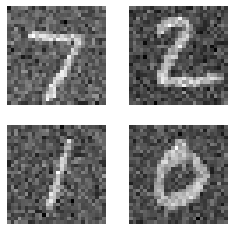

In [ ]:
def original_image(model, images):
  
  fig = plt.figure(figsize=(4,4))

  for i in range(images.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(images[i, 0, :, :], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

images = test_images_norm_noisy[:4]
#images = train_images_norm[:4]
original_image(model, images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


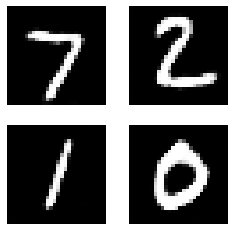

In [ ]:
def reconstructed_images(model, test_input):
    test_input = torch.tensor(test_input)

    test_input = test_input.to(device, dtype=torch.float)
    rec_images, _, mu, log_var = model(test_input)
    #z = model.reparameterize(mu, log_var)
    #predictions = model.decode(z, apply_sigmoid=True)
    #predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    rec_images = rec_images.detach().cpu()
    for i in range(rec_images.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow(rec_images[i, 0, :, :], cmap='gray')
        plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

reconstructed_images(model, images)

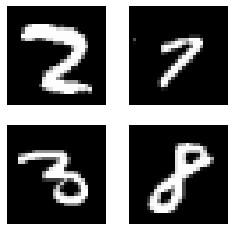

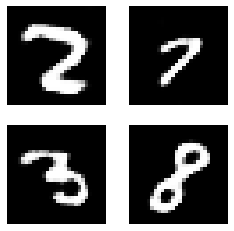

KeyboardInterrupt: ignored

In [ ]:
cnt = 0

for i in range(0,100, 4):
  images = train_images_norm[i:4+i]
  #print(image.shape)
  original_image(model, images)
  reconstructed_images(model, images)
  time.sleep(5)
  display.clear_output(wait=False)
  cnt += 1
  if cnt > 10:
    sys.exit()

### Exercise

0. Review the full code;
1. Define and compute evaluation function evaluate(valid_loader);
2. Train the model with different latent_dim = 5, 20, 50, 100
3. Modify the code and built a Denoising VAE: 

    noisy_image -> VAE -> cleaned_image  

    noisy_image = image + 0.2 * np.random.randn(shape(image))

  